# Annotate the differential abundance results

In [213]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from pathlib import Path
import requests
from matplotlib.patches import Patch
import xml.etree.ElementTree as ET
from typing import List, Dict, Tuple
import time
from Bio.KEGG import REST


%matplotlib inline

In [17]:
# set pd column width to display full text
pd.set_option('display.max_colwidth', 150)

In [3]:
# get project root by finding .git folder
root = !git rev-parse --show-toplevel
root = Path(root[0])

# assigning variables throughout the notebook
raw_data_dir = root / "data" / "raw"
data_dir = root / "data" / "processed"
vis_dir  = root / "results"

In [38]:
import sys
sys.path.append(root.as_posix())

from secret import BIOCYC_PW, BIOCYC_USER
import utils

## KEGG

In [78]:
ko_vis_dir = vis_dir / "ko_metagenome_downstream_analysis"

In [79]:
lfc_ko = pd.read_csv(ko_vis_dir / "significant_pathways_by_cohort.csv")
lfc_ko.head()

,metagene,log2foldchange_After abduction,q-value_After abduction
0,K00030,-2.254679,0.036895
1,K00042,-1.641490,0.012549
2,K00076,-2.008130,0.025288
3,K00087,-1.806933,0.020815
4,K00108,1.880564,0.012559


In [152]:
se_ko = pd.read_csv(
    data_dir
    / "ko_metagenome_downstream_analysis"
    / "ancombc_differentials_cohort"
    / "se_slice.csv"
)
se_ko = se_ko.drop(columns=["(Intercept)"])
se_ko = se_ko.rename(columns={"id": "metagene", "cohortAfter abduction": "se"})
se_ko.head()

,metagene,se
0,K00001,0.373263
1,K00003,0.334746
2,K00004,0.436775
3,K00005,0.304835
4,K00007,0.421504


In [174]:
lfc_ko_with_se = pd.merge(lfc_ko, se_ko, on="metagene", how="left")
lfc_ko_with_se.head()

,metagene,log2foldchange_After abduction,q-value_After abduction,se
0,K00030,-2.254679,0.036895,0.501846
1,K00042,-1.641490,0.012549,0.347832
2,K00076,-2.008130,0.025288,0.439088
3,K00087,-1.806933,0.020815,0.391599
4,K00108,1.880564,0.012559,0.398508


In [181]:
lfc_ko_with_se = lfc_ko_with_se.sort_values(
    "log2foldchange_After abduction", ascending=True
)

In [223]:
def get_ko_info(ko_number: str) -> str:
    """
    Retrieve information for a KEGG Orthology (KO) number

    Args:
        ko_number (str): KO number (e.g., 'K00030')

    Returns:
        str: KO name
    """
    kegg_url = f"http://rest.kegg.jp/find/ko/{ko_number}"
    while True:
        try:
            response = requests.get(kegg_url)
            break
        except requests.exceptions.ConnectionError:
            time.sleep(5)
            continue
    if response.status_code != 200:
        return None, None
    *_, name = response.text.split("\t")[1].split(";")
    name = name.strip()
    return name

In [229]:
lfc_ko_with_se["name"] = lfc_ko_with_se["metagene"].apply(get_ko_info)

In [231]:
lfc_ko_with_se.head(10)

,metagene,log2foldchange_After abduction,q-value_After abduction,se,name
22,K00689,-3.296469,0.000148,0.593244,dextransucrase [EC:2.4.1.5]
131,K07650,-3.042066,0.000030,0.521689,"two-component system, OmpR family, sensor histidine kinase CssS [EC:2.7.13.3]"
117,K06859,-2.929887,0.000566,0.551036,"glucose-6-phosphate isomerase, archaeal [EC:5.3.1.9]"
139,K09116,-2.818665,0.006515,0.580972,"damage-control phosphatase, subfamily I [EC:3.1.3.-]"
140,K09696,-2.790146,0.000030,0.478673,sodium transport system permease protein
141,K09697,-2.771799,0.000036,0.478026,sodium transport system ATP-binding protein [EC:7.2.2.4]
59,K03390,-2.724815,0.000998,0.522741,heterodisulfide reductase subunit C2 [EC:1.8.7.3 1.8.98.4 1.8.98.5 1.8.98.6]
135,K07770,-2.720148,0.000270,0.499039,"two-component system, OmpR family, response regulator CssR"
111,K06408,-2.718368,0.000196,0.493592,stage V sporulation protein AF
26,K00952,-2.689326,0.028147,0.590981,nicotinamide-nucleotide adenylyltransferase [EC:2.7.7.1]


In [232]:
lfc_ko_with_se.tail(10)

,metagene,log2foldchange_After abduction,q-value_After abduction,se,name
56,K03328,2.052910,0.037260,0.457154,"polysaccharide transporter, PST family"
146,K10009,2.098519,0.002248,0.414777,L-cystine transport system permease protein
163,K16012,2.110546,0.003441,0.424038,"ATP-binding cassette, subfamily C, bacterial CydC"
147,K10010,2.140942,0.004184,0.433471,L-cystine transport system ATP-binding protein [EC:7.4.2.1]
61,K03635,2.195920,0.003588,0.441922,molybdopterin synthase catalytic subunit [EC:2.8.1.12]
46,K02424,2.205921,0.002335,0.436636,L-cystine transport system substrate-binding protein
72,K05340,2.218735,0.016850,0.476281,glucose uptake protein
48,K02538,2.408123,0.019551,0.520396,mannose operon transcriptional activator
138,K08996,2.442510,0.011410,0.515438,putative membrane protein
159,K14194,3.079944,0.029857,0.678716,serine-aspartate repeat-containing protein C/D/E


In [230]:
lfc_ko_with_se.to_csv(ko_vis_dir / "significant_ko_by_cohort_annotated.csv", index=False)

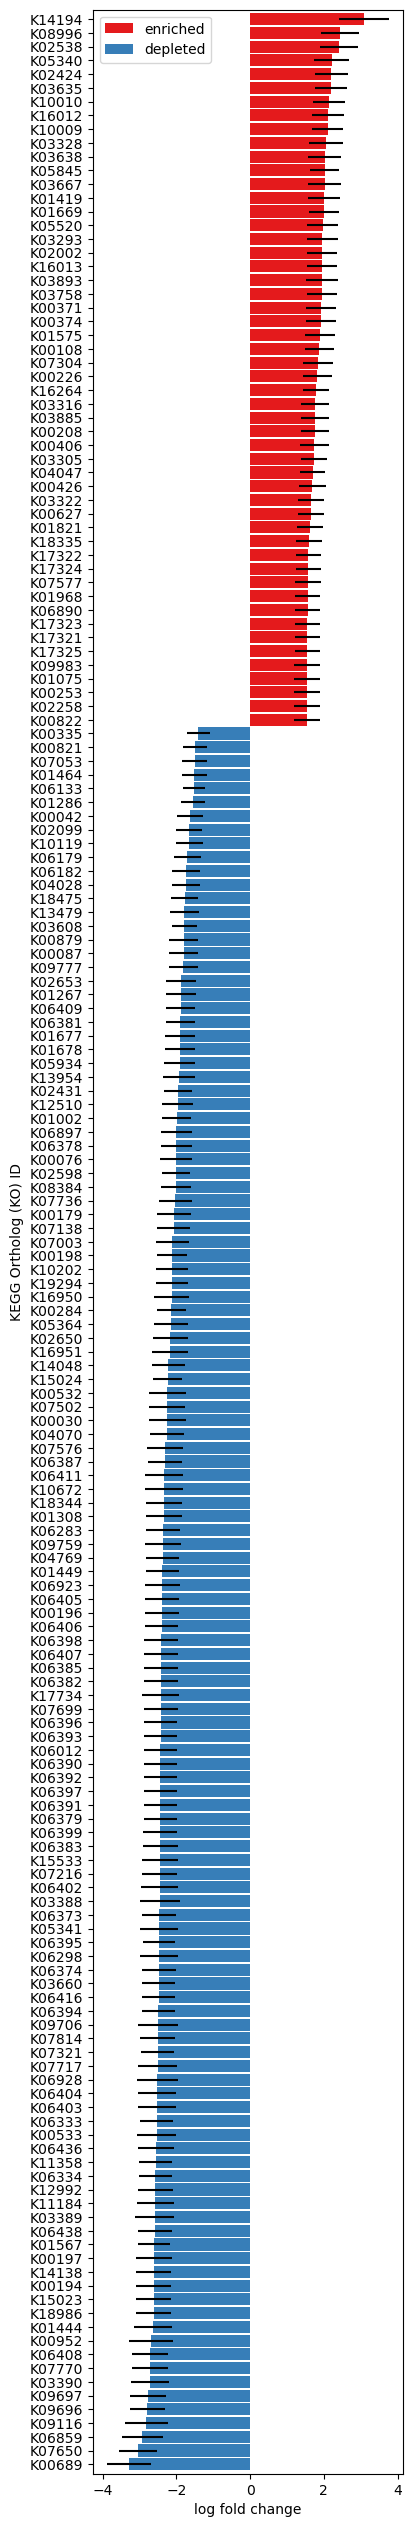

In [ ]:
# plot the log2foldchange of enzymes as a bar plot
barh_styles = {"width": 0.88}

palette = sns.color_palette("Set1", 2)
colors = [
    palette[0] if x > 0 else palette[1]
    for x in lfc_ko_with_se["log2foldchange_After abduction"]
]

ax = lfc_ko_with_se.plot.barh(
    x="metagene",
    y="log2foldchange_After abduction",
    xerr="se",
    figsize=(4, 32),
    color=colors,
    **barh_styles
)

ax.set_ylabel("KEGG Ortholog (KO) ID")
ax.set_xlabel("log fold change")

legend_elements = [
    Patch(facecolor=palette[0], label="enriched"),
    Patch(facecolor=palette[1], label="depleted"),
]
ax.legend(handles=legend_elements, loc="upper left", title="Relative to Cohort 1 (before abduction)")
ax.get_figure().savefig(ko_vis_dir / "ko_da_barplot.png", dpi=300)

## EC

In [12]:
ec_vis_dir = vis_dir / "ec_metagenome_downstream_analysis"

Download EXPASY enzyme database as a reference for EC numbers.

In [4]:
! wget -O $data_dir/ec_metagenome_downstream_analysis/enzyme.dat https://ftp.expasy.org/databases/enzyme/enzyme.dat

--2024-12-21 16:19:29--  https://ftp.expasy.org/databases/enzyme/enzyme.dat
Resolving ftp.expasy.org (ftp.expasy.org)... 192.33.215.162
Connecting to ftp.expasy.org (ftp.expasy.org)|192.33.215.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9428206 (9.0M) [text/plain]
Saving to: ‘/home/matchy233/study/alien/data/processed/ec_metagenome_downstream_analysis/enzyme.dat’

/home/matchy233/stu 100%[===================>]   8.99M  31.6MB/s    in 0.3s    

2024-12-21 16:19:29 (31.6 MB/s) - ‘/home/matchy233/study/alien/data/processed/ec_metagenome_downstream_analysis/enzyme.dat’ saved [9428206/9428206]



Read previous results (from `07_b_downstream_analysis/02_ec_analysis.ipynb`) 

In [30]:
lfc_ec = pd.read_csv(ec_vis_dir / "significant_enzymes_by_cohort.csv")
lfc_ec.head()

,metagene,log2foldchange_After abduction,q-value_After abduction
0,EC:1.1.1.103,-1.687152,0.040528
1,EC:1.1.1.14,-1.845816,0.000927
2,EC:1.1.1.159,-2.563178,0.000004
3,EC:1.1.1.261,-2.384744,0.000262
4,EC:1.1.1.267,-1.575203,0.000110


In [31]:
# define top level enzyme classes
enzyme_mapping_level1 = {
    "EC:1": "Oxidoreductases",
    "EC:2": "Transferases",
    "EC:3": "Hydrolases",
    "EC:4": "Lyases",
    "EC:5": "Isomerases",
    "EC:6": "Ligases",
    "EC:7": "Translocases",
}


In [32]:
# use the mapping to get the level 1 enzyme class
lfc_ec["enzyme_class"] = lfc_ec.loc[:,"metagene"].apply(
    lambda x: enzyme_mapping_level1[x.split(".")[0]]
)


In [123]:
lfc_ec["enzyme_class"].value_counts()

enzyme_class
Transferases       46
Oxidoreductases    42
Hydrolases         26
Isomerases         14
Lyases             14
Ligases            10
Name: count, dtype: int64

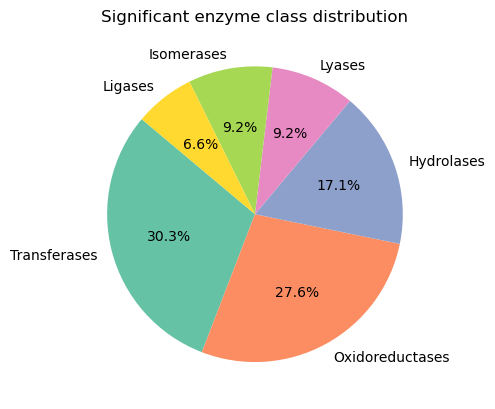

In [33]:
# plot enzyme class distribution as a pie chart
ax = lfc_ec["enzyme_class"].value_counts().plot.pie(
    autopct="%1.1f%%", startangle=140, colors=sns.color_palette("Set2")
)
ax.set_ylabel("")
ax.set_title("Significant enzyme class distribution")

plt.savefig(ec_vis_dir / "significant_enzyme_class_pie_chart.png", dpi=300)

In [34]:
# import biopython ExPASy module
from Bio.ExPASy import Enzyme
handle = open(data_dir / "ec_metagenome_downstream_analysis" / "enzyme.dat")
records = Enzyme.parse(handle)
enzyme_mapping = {
    record["ID"]: record["DE"].rstrip(".") for record in records
}

In [35]:
# sort lfc_qval_significant by lfc
lfc_ec["enzyme"] = lfc_ec["metagene"].apply(
    lambda x: enzyme_mapping.get(x.split(":")[1], "Unknown")
)
lfc_ec = lfc_ec.sort_values(by="log2foldchange_After abduction", ascending=True)

# show depleted enzymes that are < 5% compared to before abduction
lfc_ec[lfc_ec["log2foldchange_After abduction"] < -3][["metagene", "enzyme_class", "enzyme"]]


,metagene,enzyme_class,enzyme
61,EC:2.4.1.5,Transferases,dextransucrase
51,EC:2.1.1.245,Transferases,5-methyltetrahydrosarcinapterin:corrinoid/iron-sulfur proteinCo-methyltransferase
100,EC:3.5.1.26,Hydrolases,N(4)-(beta-N-acetylglucosaminyl)-L-asparaginase
54,EC:2.1.1.258,Transferases,5-methyltetrahydrofolate:corrinoid/iron-sulfur proteinCo-methyltransferase
56,EC:2.3.1.169,Transferases,CO-methylating acetyl-CoA synthase
40,EC:1.8.98.1,Oxidoreductases,dihydromethanophenazine:CoB--CoM heterodisulfide reductase
60,EC:2.4.1.4,Transferases,amylosucrase
58,EC:2.4.1.211,Transferases,"1,3-beta-galactosyl-N-acetylhexosamine phosphorylase"
110,EC:3.6.1.15,Hydrolases,nucleoside-triphosphate phosphatase


In [121]:
lfc_ec[lfc_ec["log2foldchange_After abduction"] < -3]["enzyme_class"].value_counts()

enzyme_class
Transferases       6
Hydrolases         2
Oxidoreductases    1
Name: count, dtype: int64

<Axes: ylabel='count'>

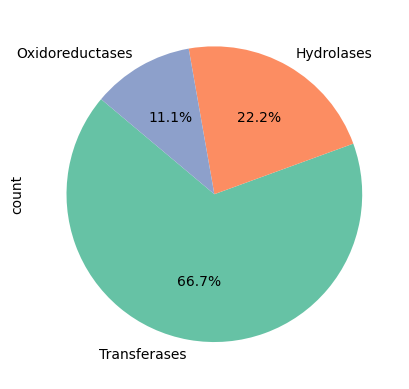

In [120]:
lfc_ec[lfc_ec["log2foldchange_After abduction"] < -3]["enzyme_class"].value_counts().plot.pie(
    autopct="%1.1f%%", startangle=140, colors=sns.color_palette("Set2")
)

In [89]:
lfc_ec[lfc_ec["log2foldchange_After abduction"] < 0].shape[0]

152

In [134]:
se_ec = pd.read_csv(
    data_dir
    / "ec_metagenome_downstream_analysis"
    / "ancombc_differentials_cohort"
    / "se_slice.csv"
)
se_ec = se_ec.drop(columns=["(Intercept)"])
se_ec = se_ec.rename(columns={"id": "metagene", "cohortAfter abduction": "se"})
se_ec.head()

,metagene,se
0,EC:1.1.1.1,0.239708
1,EC:1.1.1.100,0.254684
2,EC:1.1.1.103,0.400387
3,EC:1.1.1.108,0.553945
4,EC:1.1.1.11,0.452219


In [135]:
lfc_ec_with_se = lfc_ec.merge(se_ec, on="metagene", how="left")
assert len(lfc_ec) == len(lfc_ec_with_se)

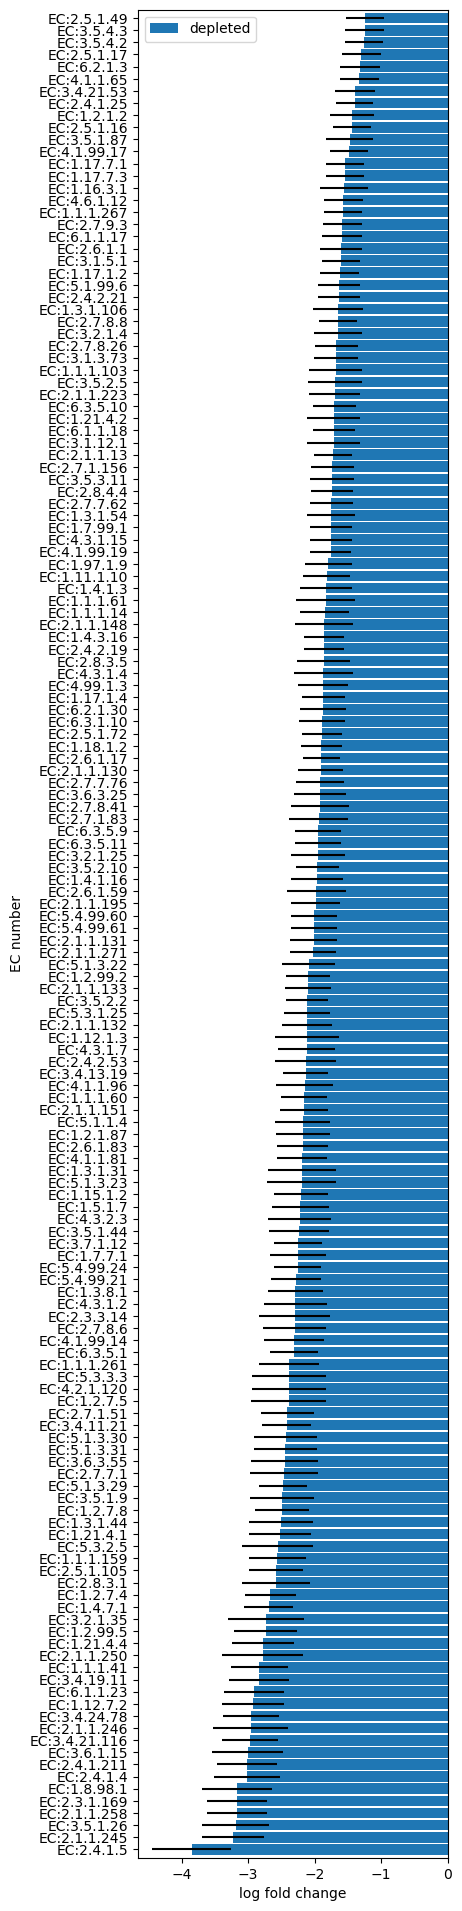

In [148]:
# plot the log2foldchange of enzymes as a bar plot
ax = lfc_ec_with_se.plot.barh(
    y="log2foldchange_After abduction",
    x="metagene",
    figsize=(4, 24),
    width=0.88,
    xerr="se",
    label="depleted"
)

ax.set_ylabel("EC number")
ax.set_xlabel("log fold change")
ax.legend(loc="upper left")

ax.get_figure().savefig(ec_vis_dir / "ec_da_barplot.png", dpi=300)

In [36]:
lfc_ec.to_csv(ec_vis_dir / "significant_enzymes_by_cohort_annotated.csv", index=False)

### MetaCyc pathways

In [44]:
pathabun_vis_dir = vis_dir / "pathway_abundance_downstream_analysis"

### By Cohort

In [46]:
lfc_metacyc = pd.read_csv(pathabun_vis_dir / "significant_pathways_by_cohort.csv")
lfc_metacyc.head()

,metagene,log2foldchange_After abduction,q-value_After abduction
0,ARG+POLYAMINE-SYN,-1.127526,0.003732
1,ASPASN-PWY,-1.230605,0.000123
2,CENTFERM-PWY,-1.625897,0.000388
3,COBALSYN-PWY,-1.637630,0.000092
4,DAPLYSINESYN-PWY,-1.094884,0.000129


In [70]:
def get_pathway_name_from_biocyc(session: requests.Session, pathway_id: str):
    URL = f"https://websvc.biocyc.org/getxml?id=META:{pathway_id}"
    response = session.get(URL)
    if response.status_code != 200:
        return "Unknown"
    root = ET.fromstring(response.text)
    pathway_name = root.find(".//Pathway/common-name").text
    return pathway_name

In [47]:
# connect to BioCyc
s = requests.Session()  # create session
# Post login credentials to session:
r = s.post(
    "https://websvc.biocyc.org/credentials/login/",
    data={"email": BIOCYC_USER, "password": BIOCYC_PW},
)

# Check if login was successful
r.status_code


200

In [71]:
lfc_metacyc["pathway_name"] = lfc_metacyc["metagene"].apply(
    lambda x: get_pathway_name_from_biocyc(s, x)
)
lfc_metacyc.head()

,metagene,log2foldchange_After abduction,q-value_After abduction,pathway_name
0,ARG+POLYAMINE-SYN,-1.127526,0.003732,Unknown
1,ASPASN-PWY,-1.230605,0.000123,superpathway of L-aspartate and L-asparagine biosynthesis
2,CENTFERM-PWY,-1.625897,0.000388,pyruvate fermentation to butanoate
3,COBALSYN-PWY,-1.637630,0.000092,superpathway of adenosylcobalamin salvage from cobinamide I
4,DAPLYSINESYN-PWY,-1.094884,0.000129,L-lysine biosynthesis I


In [98]:
# remove <i> tags from pathway names
lfc_metacyc["pathway_name"] = (
    lfc_metacyc["pathway_name"].str.replace("<i>", "").str.replace("</i>", "").str.replace("<I>", "").str.replace("</I>", "")
)
lfc_metacyc = lfc_metacyc.sort_values(
    by="log2foldchange_After abduction", ascending=True
)
lfc_metacyc.head(20)

,metagene,log2foldchange_After abduction,q-value_After abduction,pathway_name
10,METH-ACETATE-PWY,-3.053729,1.004840e-08,methanogenesis from acetate
44,PWY-7332,-2.889324,2.581338e-03,superpathway of UDP-N-acetylglucosamine-derived O-antigen building blocks biosynthesis
11,NAD-BIOSYNTHESIS-II,-2.519755,2.837803e-05,NAD salvage pathway III (to nicotinamide riboside)
6,FUCCAT-PWY,-2.422689,1.664643e-09,L-fucose degradation I
40,PWY-7198,-2.396626,1.639304e-03,pyrimidine deoxyribonucleotides de novo biosynthesis IV
41,PWY-7210,-2.372636,2.498562e-03,pyrimidine deoxyribonucleotides biosynthesis from CTP
25,PWY-5676,-2.369860,3.555472e-02,acetyl-CoA fermentation to butanoate
13,P162-PWY,-2.325231,1.902229e-03,L-glutamate degradation V (via hydroxyglutarate)
28,PWY-5705,-2.304107,4.970931e-07,allantoin degradation to glyoxylate III
26,PWY-5677,-2.296525,4.348278e-04,succinate fermentation to butanoate


In [99]:
lfc_metacyc.to_csv(pathabun_vis_dir / "significant_pathways_by_cohort_annotated.csv", index=False)

In [122]:
BIOSYNTHESIS_PATHWAYS = lfc_metacyc["pathway_name"].str.contains("biosynthesis", case=False)
print(f"Number of biosynthesis pathways: {BIOSYNTHESIS_PATHWAYS.sum()}")
lfc_metacyc[BIOSYNTHESIS_PATHWAYS]

Number of biosynthesis pathways: 23


,metagene,log2foldchange_After abduction,q-value_After abduction,pathway_name
44,PWY-7332,-2.889324,2.581338e-03,superpathway of UDP-N-acetylglucosamine-derived O-antigen building blocks biosynthesis
40,PWY-7198,-2.396626,1.639304e-03,pyrimidine deoxyribonucleotides de novo biosynthesis IV
41,PWY-7210,-2.372636,2.498562e-03,pyrimidine deoxyribonucleotides biosynthesis from CTP
45,PWY-7377,-2.111335,6.106383e-06,"cob(II)yrinate a,c-diamide biosynthesis I (early cobalt insertion)"
23,PWY-5505,-2.095994,1.149952e-09,L-glutamate and L-glutamine biosynthesis
43,PWY-7315,-1.921947,9.278025e-04,dTDP-N-acetylthomosamine biosynthesis
24,PWY-5509,-1.836686,9.799969e-06,adenosylcobalamin biosynthesis from adenosylcobinamide-GDP I
52,PYRIDNUCSYN-PWY,-1.727661,1.007609e-07,NAD de novo biosynthesis I
31,PWY-6545,-1.677948,2.512806e-04,pyrimidine deoxyribonucleotides de novo biosynthesis III
16,POLYAMINSYN3-PWY,-1.624108,9.701233e-06,superpathway of polyamine biosynthesis II


In [118]:
lfc_not_biosynthesis = lfc_metacyc[~BIOSYNTHESIS_PATHWAYS]
DEGRADATION_PATHWAYS = lfc_not_biosynthesis["pathway_name"].str.contains("degradation", case=False)
print(f"Number of degradation pathways: {lfc_not_biosynthesis[DEGRADATION_PATHWAYS].shape[0]}")
lfc_not_biosynthesis[DEGRADATION_PATHWAYS]

Number of degradation pathways: 17


,metagene,log2foldchange_After abduction,q-value_After abduction,pathway_name
6,FUCCAT-PWY,-2.422689,1.664643e-09,L-fucose degradation I
13,P162-PWY,-2.325231,1.902229e-03,L-glutamate degradation V (via hydroxyglutarate)
28,PWY-5705,-2.304107,4.970931e-07,allantoin degradation to glyoxylate III
48,PWY0-41,-2.016754,1.987432e-03,allantoin degradation IV (anaerobic)
39,PWY-7013,-1.886439,4.704758e-02,"(S)-propane-1,2-diol degradation"
5,FUC-RHAMCAT-PWY,-1.826017,1.429951e-07,superpathway of fucose and rhamnose degradation
9,GOLPDLCAT-PWY,-1.798263,2.676592e-02,"superpathway of glycerol degradation to 1,3-propanediol"
20,PWY-5180,-1.754303,4.462717e-02,toluene degradation I (aerobic) (via o-cresol)
14,P164-PWY,-1.579075,2.223855e-05,purine nucleobases degradation I (anaerobic)
53,SALVADEHYPOX-PWY,-1.525028,1.136097e-06,adenosine nucleotides degradation II


In [119]:
not_syn_or_deg = lfc_not_biosynthesis[~DEGRADATION_PATHWAYS]
print(f"Number of other pathways: {not_syn_or_deg.shape[0]}")
not_syn_or_deg

Number of other pathways: 17


,metagene,log2foldchange_After abduction,q-value_After abduction,pathway_name
10,METH-ACETATE-PWY,-3.053729,1.004840e-08,methanogenesis from acetate
11,NAD-BIOSYNTHESIS-II,-2.519755,2.837803e-05,NAD salvage pathway III (to nicotinamide riboside)
25,PWY-5676,-2.369860,3.555472e-02,acetyl-CoA fermentation to butanoate
26,PWY-5677,-2.296525,4.348278e-04,succinate fermentation to butanoate
50,PWY490-3,-2.294519,2.607235e-05,nitrate reduction VI (assimilatory)
29,PWY-6269,-1.842784,9.504057e-06,superpathway of adenosylcobalamin salvage from cobinamide II
21,PWY-5182,-1.754303,4.462717e-02,Unknown
32,PWY-6590,-1.656778,3.129751e-04,superpathway of Clostridium acetobutylicum acidogenic fermentation
3,COBALSYN-PWY,-1.637630,9.226525e-05,superpathway of adenosylcobalamin salvage from cobinamide I
2,CENTFERM-PWY,-1.625897,3.881718e-04,pyruvate fermentation to butanoate


### By Stool Consistency


In [90]:
lfc_metacyc_stool = pd.read_csv(pathabun_vis_dir / "significant_pathways_by_stool_consistency_liquid.csv")

In [91]:
lfc_metacyc_stool.head()

,metagene,log2foldchange_liquid,log2foldchange_semi-formed,q-value_liquid,q-value_semi-formed
0,PWY-5180,2.141376,0.631737,0.022271,1
1,PWY-5182,2.141376,0.631737,0.022271,1


In [97]:
lfc_metacyc_stool["pathway_name"] = lfc_metacyc_stool["metagene"].apply(
    lambda x: get_pathway_name_from_biocyc(s, x)
)
lfc_metacyc_stool["pathway_name"] = lfc_metacyc_stool["pathway_name"].str.replace("<I>", "").str.replace("</I>", "").str.replace("<i>", "").str.replace("</i>", "")
lfc_metacyc_stool.head()

,metagene,log2foldchange_liquid,log2foldchange_semi-formed,q-value_liquid,q-value_semi-formed,pathway_name
0,PWY-5180,2.141376,0.631737,0.022271,1,toluene degradation I (aerobic) (via o-cresol)
1,PWY-5182,2.141376,0.631737,0.022271,1,Unknown
